# Debug issue with contour integral version of leaky modes

The paper method works well, but ours doesn't.  Here we try to figure out why.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from slab import SlabExact
from fiberamp.fiber.microstruct.bragg import plotlogf, plotlogf_real, plotlogf_imag
from scipy.optimize import newton
from scipy.integrate import quad
from IPython.display import Video

import json

plt.style.use('dark_background')
%matplotlib widget

In [7]:
A = SlabExact(scale=1e-6, Ts=[2., 2., 2.], xrefs=[300, 500, 300],
              ns=[1.44, 1, 1.44], wl=1e-6, symmetric=True)


In [8]:
Ftest = A.fields_Z(8+.5j, mode_type='radiation', paper_method=False)

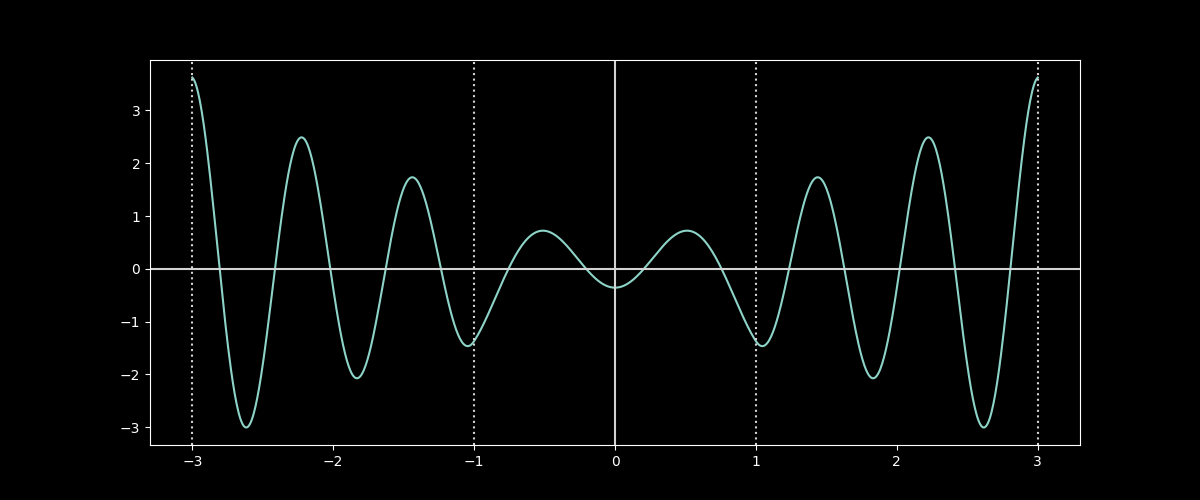

In [9]:
A.plot_field_1d(Ftest);

In [10]:
def quadratic_piecewise(x):
    conds = [(x<-.5), ((-.5<=x)*(x<=.5)), (x>.5)]
    funcs = [0, lambda x: .25-x**2, 0]
    return np.piecewise(x, conds, funcs)

In [11]:
# Set input function
f0 = quadratic_piecewise
f0_shifted = lambda x: f0(x) + 1
# Set input field type
field_type = 'TE'

## Forming leaky mode from contour integral

Leaky modes should arise from residuals when deforming contour of integration to steepest descent path.  But I don't know how to calculate the residuals analytically.  Here I try to do it numerically by doing a circular contour integration around a leaky mode propagation constant in the complex plane.  First I'll grab that propagation constant in the Z plane:

### Paper method

We discovered from the notebook Integrand/Full/Exact_Delta_Integrand_and_Contour_Integrals that with the paper method there are poles in the negative real part of the complex plane that appear to work.  These appear at what would be "leaky" mode_types with negative real parts.  Need to understand how it is that these can give correct decay and propagation direction.

In [12]:
mode_type='leaky'

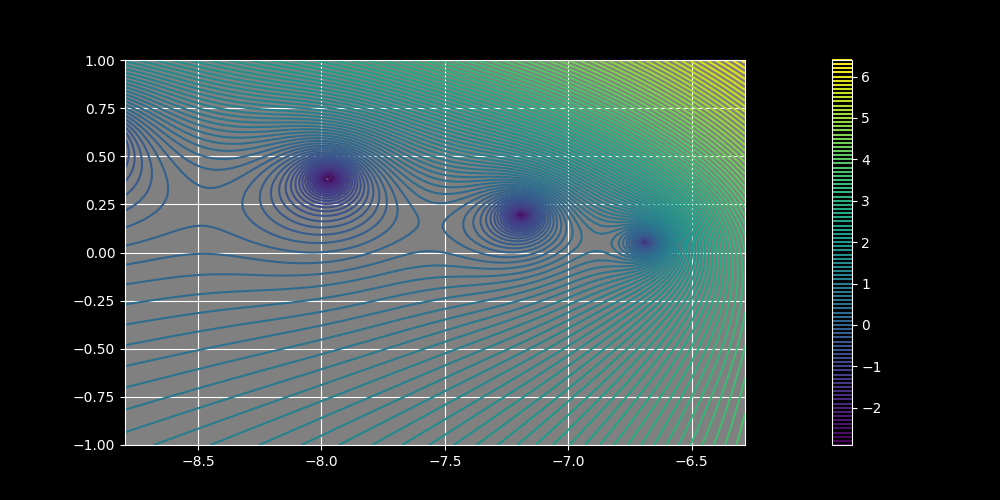

In [13]:
plotlogf(A.determinant_Z, -1.4*A.K_low, -A.K_low, -1,1, field_type, mode_type,
         figsize=(10,5),iref=100, rref=100,levels=100)

In [14]:
Z_leaky_theirs = newton(A.determinant_Z, -6.5, args=('TE', mode_type))
print(Z_leaky_theirs, A.determinant_Z(Z_leaky_theirs, mode_type=mode_type))
plt.plot(Z_leaky_theirs.real, Z_leaky_theirs.imag, 'ro');

(-6.685128839583154+0.0537381438821302j) (1.6176769136128868e-14-5.5945532922631366e-15j)


In [15]:
circ_contour_theirs = {'center': Z_leaky_theirs, 'radius': 1e-4, 'N':30}

In [16]:
Propagator_Class = A.propagator()

In [17]:
P_leaky_even_theirs = Propagator_Class(f0=f0, Lx=-.5, Rx=.5, 
                     LZ=100, RZ=150, NZ=10, 
                     field_type=field_type, 
                     sign='+1', circ_contour=circ_contour_theirs, paper_method=True)
P_leaky_odd_theirs = Propagator_Class(f0=f0, Lx=-.5, Rx=.5, 
                     LZ=100, RZ=150, NZ=10, 
                     field_type=field_type, 
                     sign='-1', circ_contour=circ_contour_theirs, paper_method=True)

 76% (23 of 30) |##################      | Elapsed Time: 0:00:00 ETA:   0:00:00

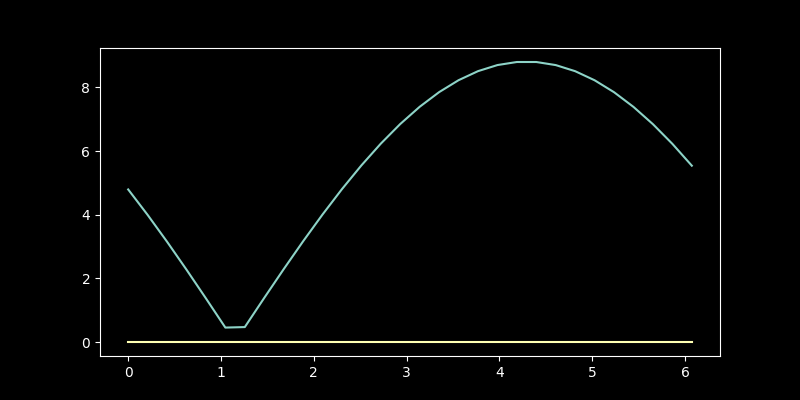

In [18]:
plt.close('all')
fig, ax = plt.subplots(1, figsize=(8,4))
ax.plot(P_leaky_even_theirs.ts,  np.abs(P_leaky_even_theirs.alphas));
ax.plot(P_leaky_odd_theirs.ts,  np.abs(P_leaky_odd_theirs.alphas));

In [19]:
P_ls_theirs = [P_leaky_even_theirs, P_leaky_odd_theirs]
portion = 'full'

full_leaky_theirs = lambda x : sum([P.slice_propagate(x, portion=portion) for P in P_ls_theirs])
Full_leaky_theirs = lambda x, z : sum([P.propagate(x, zs=z, portion=portion) for P in P_ls_theirs])
Leaky_Diff_theirs = lambda x,z: Full(x,z) - Full_leaky_theirs(x, z)

In [20]:
xs = np.linspace(-10, 10, 1000)

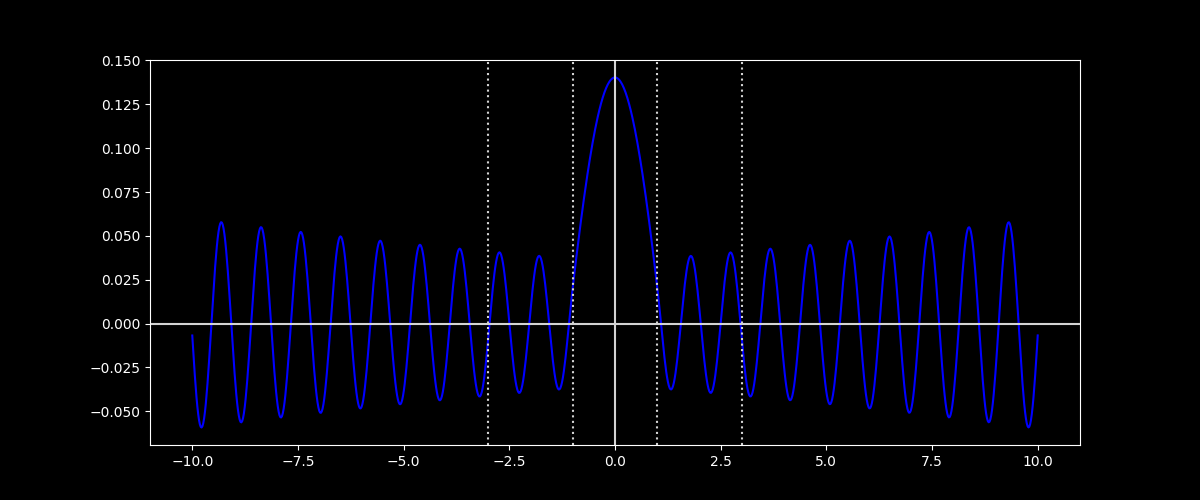

In [21]:
A.plot_field_1d(full_leaky_theirs, xs=xs, part='real', color='blue');

### Our method

This still has issues: all the contour integrals go to zero.

In [22]:
mode_type='leaky'


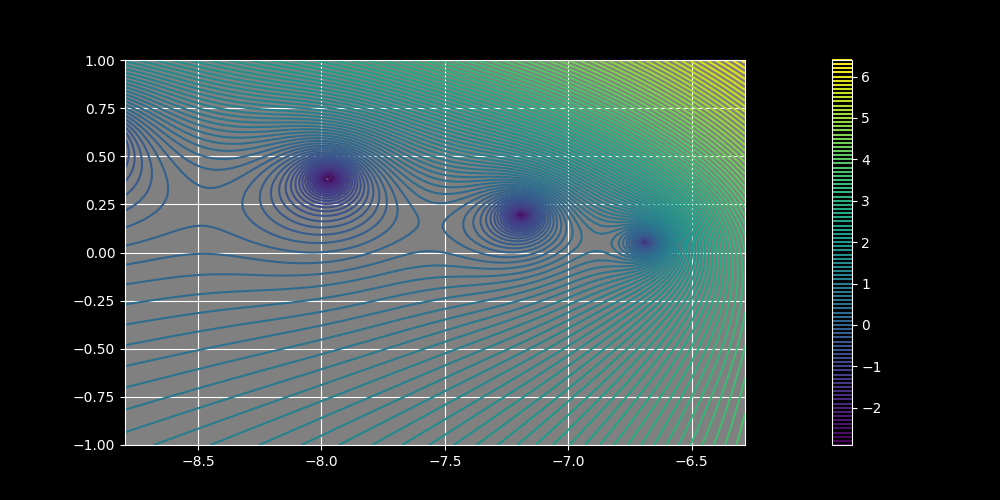

In [23]:
plotlogf(A.determinant_Z, - 1.4*A.K_low, -A.K_low, -1,1, field_type, mode_type,
         figsize=(10,5),iref=100, rref=100,levels=100)

In [24]:
Z_leaky = newton(A.determinant_Z, -6.5, args=('TE', mode_type))
Z_leaky, A.determinant_Z(Z_leaky, mode_type=mode_type)
plt.plot(Z_leaky.real, Z_leaky.imag, 'ro');

In [25]:
circ_contour = {'center': Z_leaky, 'radius': 1e-4, 'N':30}

In [26]:
P_leaky_even = Propagator_Class(f0=f0, Lx=-.5, Rx=.5, 
                     LZ=100, RZ=150, NZ=10, 
                     field_type=field_type, 
                     sign='+1', circ_contour=circ_contour, paper_method=False)

P_leaky_odd = Propagator_Class(f0=f0, Lx=-.5, Rx=.5, 
                     LZ=100, RZ=150, NZ=10, 
                     field_type=field_type, 
                     sign='-1', circ_contour=circ_contour, paper_method=False)

 80% (24 of 30) |###################     | Elapsed Time: 0:00:00 ETA:   0:00:00

In [27]:
P_ls = [P_leaky_even, P_leaky_odd]

full_leaky = lambda x : sum([P.slice_propagate(x) for P in P_ls])
Full_leaky = lambda x, z : sum([P.propagate(x, zs=z) for P in P_ls])
ratio = lambda x: full_leaky_theirs(x) / full_leaky(x)

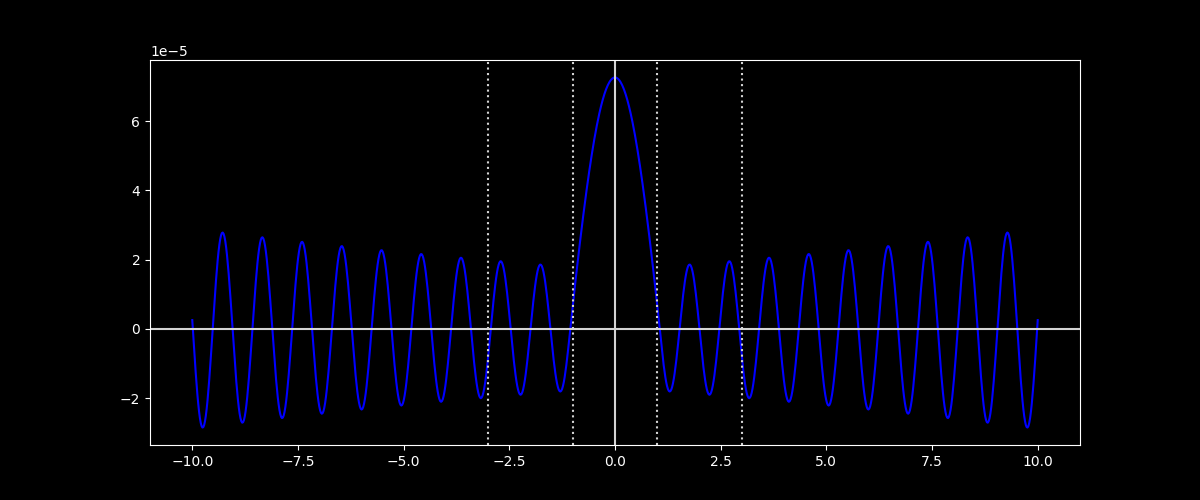

In [28]:
A.plot_field_1d(full_leaky, xs=xs, part='real', color='blue');

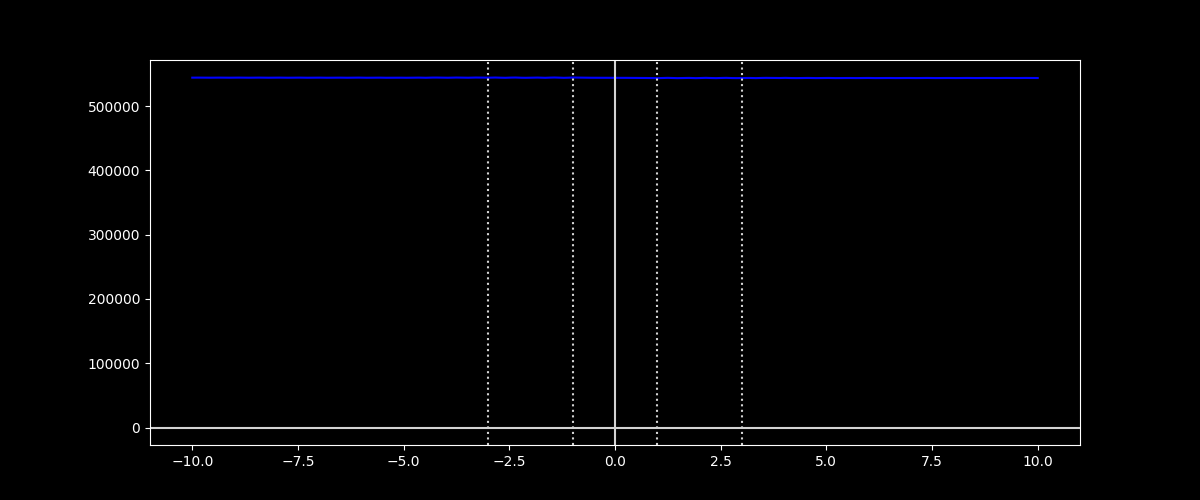

In [24]:
A.plot_field_1d(ratio, xs=xs, part='real', color='blue');

Ratio behaves like: 2 * 1/(10*radius)

## Examine Tranforms

NameError: name 'P_leaky_even' is not defined

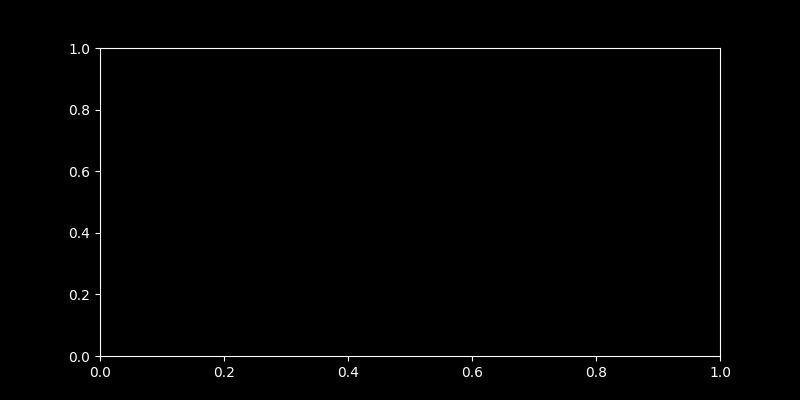

In [5]:
plt.close('all')
fig, ax = plt.subplots(1, figsize=(8,4))
ax.plot(P_leaky_even.ts,  P_leaky_even.alphas.real, label='real');
ax.plot(P_leaky_even.ts,  P_leaky_even.alphas.imag, label='imag');
ax.plot(P_leaky_even.ts,  np.abs(P_leaky_even.alphas), label='norm');
plt.legend();

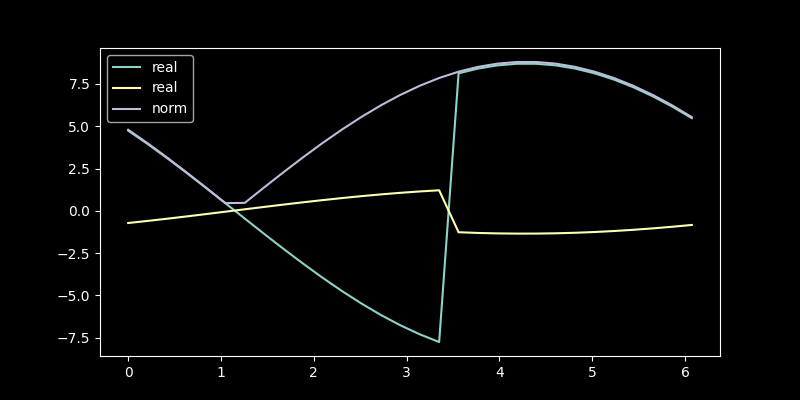

In [27]:
plt.close('all')
fig, ax = plt.subplots(1, figsize=(8,4))
ax.plot(P_leaky_even_theirs.ts,  P_leaky_even_theirs.alphas.real, label='real');
ax.plot(P_leaky_even_theirs.ts,  P_leaky_even_theirs.alphas.imag, label='real');
ax.plot(P_leaky_even_theirs.ts,  np.abs(P_leaky_even_theirs.alphas), label='norm');
plt.legend();

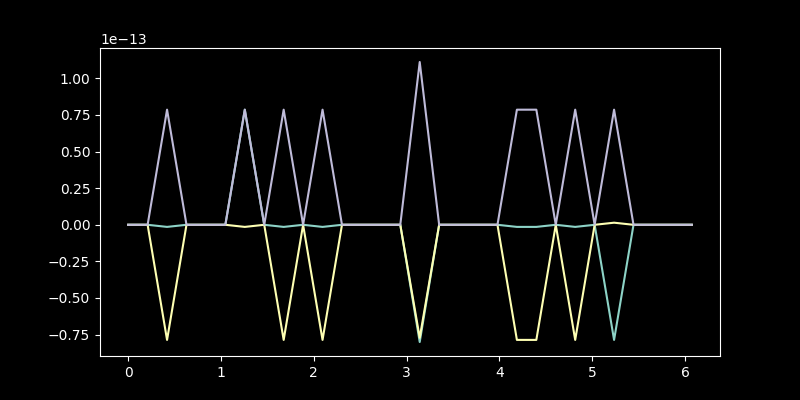

In [28]:
plt.close('all')
fig, ax = plt.subplots(1, figsize=(8,4))
ax.plot(P_leaky_odd.ts,  P_leaky_odd.alphas.real);
ax.plot(P_leaky_odd.ts,  P_leaky_odd.alphas.imag);
ax.plot(P_leaky_odd.ts,  np.abs(P_leaky_odd.alphas));

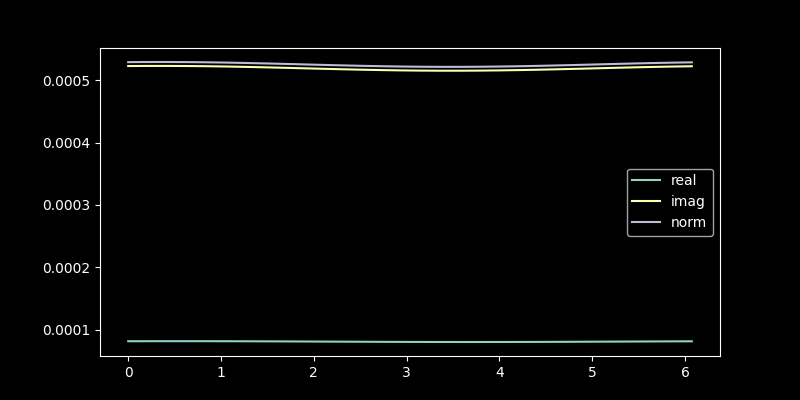

In [29]:
plt.close('all')
fig, ax = plt.subplots(1, figsize=(8,4))
ax.plot(P_leaky_odd_theirs.ts,  P_leaky_odd_theirs.alphas.real, label='real');
ax.plot(P_leaky_odd_theirs.ts,  P_leaky_odd_theirs.alphas.imag, label='imag');
ax.plot(P_leaky_odd_theirs.ts,  np.abs(P_leaky_odd_theirs.alphas), label='norm');
plt.legend()

## Examine fields

Didn't we have one where it should have integrated to zero but it didn't?